# 0. Imports & utility

In [1]:
from collections import defaultdict, Counter

import os
import subprocess
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from IPython.display import display

In [118]:
def proc_output(proc):    
    if proc.stdout:
        print(proc.stdout.decode('utf-8'))
    if proc.stderr:
        print(proc.stderr.decode('utf-8'))
    proc.check_returncode()

# 1. Illumina reads

### bowtie2 & samtools wrappers

In [2]:
def bowtie2_build(reference, output, folder='.', print_output=False):
    
    """
    cd <folder>
    bowtie2-build <reference> <output>
    """
    index = [
        'bowtie2-build',
        reference,
        output
    ]
    proc_output(subprocess.run(index, capture_output=True, cwd=folder))
    
    
        
def bowtie2(x, r1, r2, S, p=1, folder='.', print_output=False):
    
    """
    cd <folder>
    bowtie2 -x x -1 r1 -2 r2 -S S -p p
    """
    
    align = [
        'bowtie2',
        '-x', x,
        '-1', r1,
        '-2', r2,
        '-S', S,
        '-p', str(p)
    ]
    proc_output(subprocess.run(align, capture_output=True, cwd=folder))

        
def compress_sam(alignment, folder=''):
    proc_output(subprocess.run(f'samtools view -S -b {alignment} > {alignment.replace(".sam", ".bam")}', 
                              cwd=folder))

### Analysis functions

#### Insert length distribution

In [3]:
def insert_length_distribution(filename, title):    
    
    insert_size = defaultdict(int)

    with open(filename, 'r') as f:
        for line in f:
            if line[0] == '@':  # scip headers
                continue

            # 9th field according to https://samtools.github.io/hts-specs/SAMv1.pdf
            tlen = int(line.split('\t')[8])   

            # only need to count for left (or right) segments
            # TLEN > 0 indicates leftmost segment
            if tlen > 0:
                insert_size[tlen] += 1
    
    # range
    min_i_size = min(insert_size.values())
    max_i_size = max(insert_size.values())
   
    insert_size = sorted(insert_size.items())
    
    # mean
    number_of_reads = 0
    insert_size_sum = 0
    for i_size, n_reads in insert_size:
        number_of_reads += n_reads
        insert_size_sum += n_reads * i_size
    mean = insert_size_sum / number_of_reads
    
    # std
    variance = 0
    for i_size, n_reads in insert_size:
        variance += n_reads * (i_size - mean)**2
    variance /= (number_of_reads - 1)
    std = np.sqrt(variance)
    
    # 0.025 quantile
    cnr = 0 # cumulative number of reads
    q025 = 0
    for i_size, n_reads in insert_size:
        cnr += n_reads
        if cnr > 0.025 * number_of_reads:
            q025 = i_size
            break
        
    # 0.975 quantile
    cnr = 0 
    q975 = 0
    for i_size, n_reads in reversed(insert_size):
        cnr += n_reads
        if cnr > 0.025 * number_of_reads:
            q975 = i_size
            break
                
    print(f'Range = {min_i_size, max_i_size}')
    print(f'Mean = {round(mean, 3)}')
    print(f'Std = {round(std, 3)}')
    print(f'0.95 interval = {q025, q975}')
                
    highest_frequency = max([item[1] for item in insert_size])
    
    # plotting
    fig, ax = plt.subplots(1, figsize=(8, 6))
    
    # при snap=True (default) из гистограммы будут вырваны куски
    # т.е. это была не ошибка с округлением,
    # а "оптимизация" отрисовки
    ax.bar([item[0] for item in insert_size], [item[1] for item in insert_size], snap=False)
    ax.set_xlim(0, q975 + 300)
    ax.vlines([q025, q975], 0, highest_frequency / 2, label='0.95-interval', color='red')
    
    fig.suptitle('Insert length distribution (%s)' % title)
    
    ax.grid()
    ax.legend()
    
    fig.tight_layout()

#### Coverage

In [160]:
def coverage(alignment, reference, title, folder='.', step=1000):
    """
    1. Создаётся заполненный нулями массив, размер которого равен длине референса // step
    
    2. Проходим по строчкам .sam - файла. В 4 колонке - самый левая позиция, к
    к ней добавляем длину выравнивания L - сумму полей (M/I/=/X) строки CIGAR. 
    В массиве увеличиваем значения элементов по индексам (POS-1)//step : (POS + L)//step + 1
    (не включая правую границу) на величину, равную x / step, 
    где x - длина фрагмента рида, лежащего в соотв. фрагментов
    """
    
    # reference length
    length = 0
    with open(folder + reference, 'r') as f:
        for line in f:
            if line[0] != '>':
                length += len(line.strip())
    
    length = length // step # + 1
    
    coverage = np.zeros(length, dtype='float')
    
    # CIGAR string parsing
    m = re.compile(r'[0-9]+M')   # alignment matches
    i = re.compile(r'[0-9]+I')   # insertions to the reference
    eq = re.compile(r'[0-9]+=')  # sequence match
    x = re.compile(r'[0-9]+X')   # sequence mismatch
    
    cigar_fields = [m, i, eq, x]
    
    c = 0
    with open(folder + alignment, 'r') as f:
        for line in f:
            if line[0] != '@':
                c += 1
                line = line.split('\t')
                pos, cigar = line[3], line[5]
                
                pos = int(pos)
                L = 0
                
                for field in cigar_fields:
                    
                    match = re.search(field, cigar)
                    if match:
                        L += int(match[0][:-1])
                
                left = (pos - 1) // step - 1
                right = (pos - 1 + L) // step - 1
                
                # весь рид попал на один элемент массива
                if (pos + L) // step < 0:
                    coverage[left] += L / step
                else:  
                    right_x = (pos + L) % step 
                    left_x = L - right_x
                    
                    coverage[left] += left_x / step
                    coverage[right] += right_x / step
                
    #### plotting
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.grid()
    
    sns.lineplot(x=np.arange(length)+1, y=coverage, ax=ax, linewidth=2)
    
    ax.xaxis.set_major_locator(mticker.MaxNLocator(12))
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([int(x * step) for x in ticks_loc])

    ax.set_xlabel('Position in reference', fontsize=12)
    ax.set_ylabel('Covergae depth', fontsize=12)
    
    fig.suptitle('Coverage depth (%s)' % title, fontsize=15)
    
    fig.tight_layout()

#### Error frequencies

In [5]:
def error_frequencies(alignment_sam, reference, folder='./'):
    
    alignment_bam = alignment_sam.replace('.sam', '.bam')
    alignment_sorted = alignment[:-4] + '_sorted.bam'
    
    if not os.path.isfile(folder + alignment_bam):
        
        commands = [
            # compress into .bam
            f'samtools view -S -b {alignment_sam} > {alignment_bam}',  
            # sort by sequence coordinate on reference
            f"samtools sort {alignment_bam} -o {alignment_sorted} -@ 8",  
            # create index for faster search
            f'samtools index {alignment_sorted} -@ 8',
        ]
        
        for command in commands:
            subprocess.run(command, capture_output=False, shell=True, cwd=folder).check_returncode()
    
    mpileup = alignment_sam.replace('.sam', '.mpileup')
    
    if not os.path.isfile(folder + mpileup):
        subprocess.run(f'samtools mpileup -f {reference} {alignment_sorted} > {mpileup}',
                      capture_output=False, shell=True, cwd=folder).check_returncode()
        
    if not os.path.isfile(folder + 'VarScan.v2.3.9.jar'):
        subprocess.run(f'cp VarScan.v2.3.9.jar {folder + "VarScan.v2.3.9.jar"}', shell=True)
    
    vcf = alignment.replace('.sam', '.vcf')
    
    if not os.path.isfile(folder + vcf):
        varscan = [
            'java -jar VarScan.v2.3.9.jar',
            'mpileup2snp', mpileup,
            '--min-coverage', '1',
            '--min-reads', '1',
            '--min-avg-qual', '1',
            '--min-var-freq', '0',
            '--strand-filter', '0',
            '--variants', 
            '--output-vcf', '1',
            f'> {vcf}'
        ]
        proc_output(subprocess.run(' '.join(varscan), capture_output=True, shell=True, cwd=folder))
        
    
    # составление таблицы
    errors = {}
    nucl = 'ATGC'
    
    for ref in  nucl:
        errors[ref] = {alt: 0 for alt in nucl}
        
    with open(folder + vcf, 'r') as f:
        for line in f:
            if line[0] == '#':  
                continue
                
            line = line.split('\t')
            ref = line[3]
            alt = line[4]
            
            errors[ref][alt] += 1
            
    errors_df = pd.DataFrame(errors, dtype=np.int32).loc[list(nucl), list(nucl)].astype(np.int64)
    display(errors_df)
    
    # расчёт среднего числа ошибок в риде
    total_errors = errors_df.sum().sum()   
    total_length = 0
    read_count = 0
    
    with open(folder + alignment_sam, 'r') as f:
        for line in f:
            if line[0] == '@':
                continue
    
            read_count += 1
            total_length += len(line.split('\t')[9])
        
    errors_per_read = total_errors / read_count
    mean_read_length = total_length / read_count
    
    mean_read_error_freq = errors_per_read / mean_read_length
    
    print(f'Средний процент замен в ридах: {round(mean_read_error_freq * 100, 6)}%')

### 1.0 Test data

In [25]:
test_folder = 'HW2_data/test/'
r1 = 'test_1.fastq'
r2 = 'test_2.fastq'

reference = 'MG1655-K12.first10K.fasta'
index_name = 'test_reference_index'

alignment = 'test_alignment.sam'

In [7]:
# выравнивание
bowtie2_build(reference, index_name, test_folder)
bowtie2(x=index_name, r1=r1, r2=r2, S=alignment, p=8, folder=test_folder)

Определение процента выравнявшихся ридов:

In [77]:
proc_output(subprocess.run([
    'samtools', 
    'flagstat',
    alignment
], capture_output=True, cwd=test_folder))

56320 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
56320 + 0 mapped (100.00% : N/A)
56320 + 0 paired in sequencing
28160 + 0 read1
28160 + 0 read2
56320 + 0 properly paired (100.00% : N/A)
56320 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)



В тестовых данных все риды выравнились.

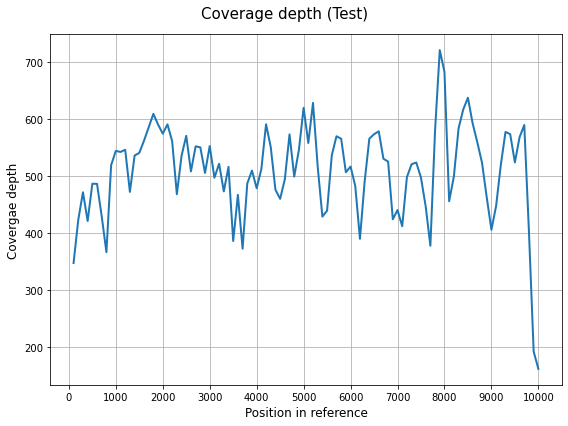

In [28]:
coverage(alignment, reference, 'Test', folder=test_folder, step=100)

Mean = 215.286
Standard deviation = 10.59
0.95 interval = (196, 234)


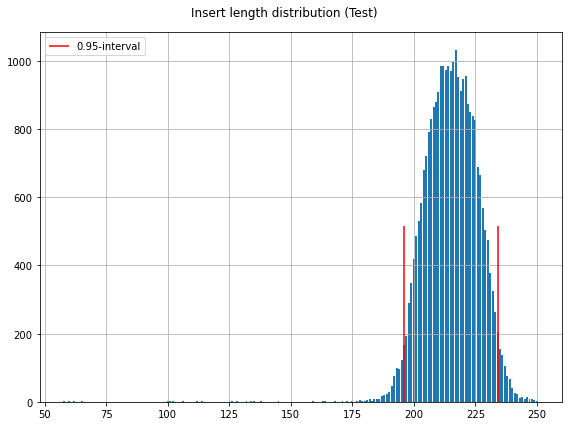

In [26]:
insert_length_distribution(test_folder + alignment, 'Test')

In [166]:
error_frequencies(alignment, reference,  test_folder)

,A,T,G,C
A,0,0,0,0
T,0,0,0,0
G,0,0,0,0
C,0,0,0,0


Средний процент ошибок в ридах: 0.0%


### 1.1 Dataset 1

In [164]:
title = 'Dataset 1'

dataset1_folder = 'HW2_data/task1/dataset1/'
r1 = '100x.1.fastq'
r2 = '100x.2.fastq'

reference = 'MG1655-K12.fasta'
index_name = 'dataset1_index'

alignment = 'dataset1_alignment.sam'

In [49]:
bowtie2_build(reference, index_name, dataset1_folder)
bowtie2(x=index_name, r1=r1, r2=r2, S=alignment, p=8, folder=dataset1_folder)

Settings:
  Output files: "dataset1_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  MG1655-K12.fasta
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1159918
Using parameters --bmax 869939 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 869939 --dcv 1024
Constructing suffix-array element generator
B

In [20]:
proc_output(subprocess.run([
    'samtools', 
    'flagstat',
    alignment
], capture_output=True, cwd=dataset1_folder))

5000000 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
4974567 + 0 mapped (99.49% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4957474 + 0 properly paired (99.15% : N/A)
4959050 + 0 with itself and mate mapped
15517 + 0 singletons (0.31% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)



99.49% reads were aligned

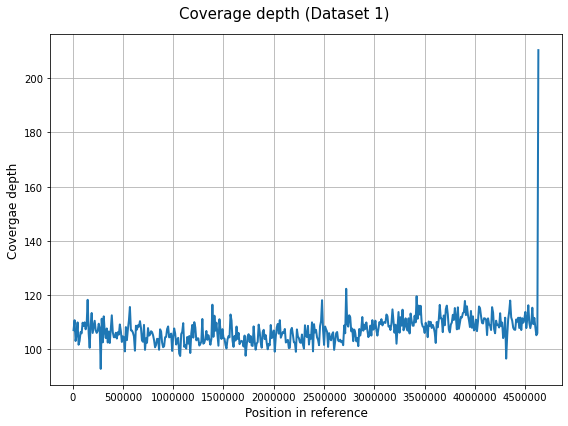

In [165]:
coverage(alignment, reference, title, folder=dataset1_folder, step=10000)

Range = (1, 88478)
Mean = 445.902
Std = 26058.35
0.95 interval = (196, 235)


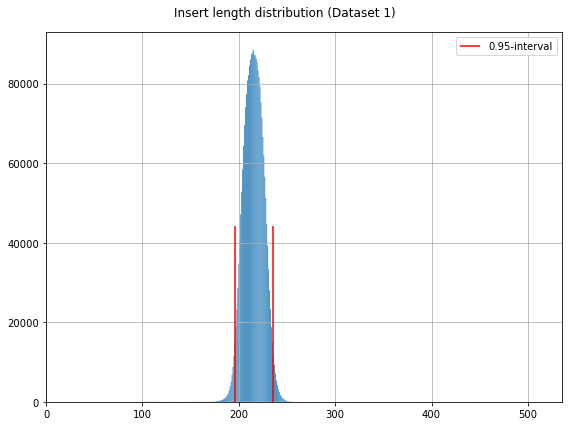

In [52]:
insert_length_distribution(dataset1_folder + alignment, title)

In [11]:
error_frequencies(alignment, reference,  dataset1_folder)

Only SNPs will be reported
Min coverage:	1
Min reads2:	2
Min var freq:	0.0
Min avg qual:	1
P-value thresh:	0.01
Reading input from dataset1_alignment.mpileup
4639675 bases in pileup file
981 variant positions (977 SNP, 4 indel)
0 were failed by the strand-filter
977 variant positions reported (977 SNP, 0 indel)



,A,T,G,C
A,0,31,24,54
T,29,0,60,31
G,108,196,0,62
C,207,96,79,0


Средний процент замен в ридах: 0.000195%


### 1.2 Dataset 2

In [167]:
title = 'Dataset 2'

dataset2_folder = 'HW2_data/task1/dataset2/'
r1 = 'ecoli_mda_lane1_left.downsampled.fastq'
r2 = 'ecoli_mda_lane1_right.downsampled.fastq'

reference = 'MG1655-K12.fasta'
index_name = 'dataset2_index'

alignment = 'dataset2_alignment.sam'

In [52]:
# выравнивание
bowtie2_build(reference, index_name, dataset2_folder)
bowtie2(x=index_name, r1=r1, r2=r2, S=alignment, p=8, folder=dataset2_folder)

Settings:
  Output files: "dataset2_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  MG1655-K12.fasta
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1159918
Using parameters --bmax 869939 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 869939 --dcv 1024
Constructing suffix-array element generator
B

В этих данных выравнялось 92,7% ридов.

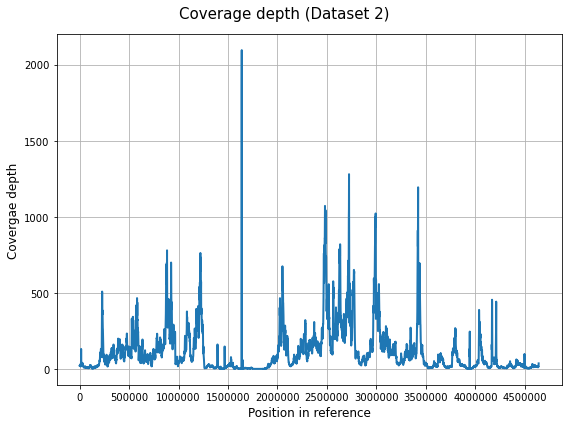

In [169]:
coverage(alignment, reference, title, folder=dataset2_folder, step=1000)

Range = (1, 37604)
Mean = 18067.305
Std = 183922.832
0.95 interval = (106, 339)


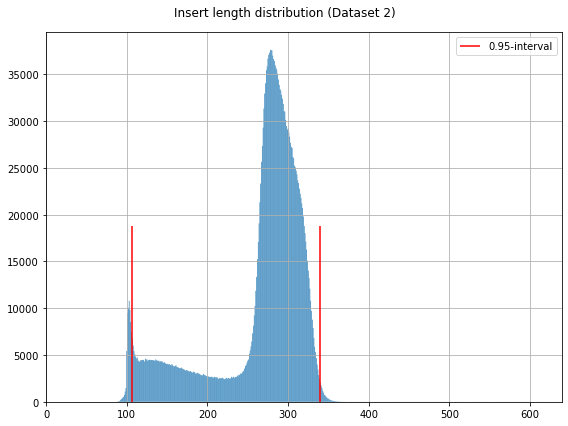

In [56]:
insert_length_distribution(dataset2_folder + alignment, title)

In [57]:
error_frequencies(alignment, reference,  dataset2_folder)

Only SNPs will be reported
Min coverage:	1
Min reads2:	2
Min var freq:	0.0
Min avg qual:	1
P-value thresh:	0.01
Reading input from dataset2_alignment.mpileup
4462090 bases in pileup file
28171 variant positions (28061 SNP, 110 indel)
0 were failed by the strand-filter
28061 variant positions reported (28061 SNP, 0 indel)



,A,T,G,C
A,0,761,833,1680
T,703,0,1680,836
G,2567,6326,0,1389
C,6809,2916,1561,0


Средний процент замен в ридах: 0.004814%


---
---

# 2. Ion Torrent reads

### bwa wrappers

In [119]:
def bwa_index(reference, folder):
    """
    cd <folder>
    bwa index <reference>
    """
    index = ['bwa', 'index', reference]
    proc_output(subprocess.run(index, capture_output=True, cwd=folder))
    
def bwa_mem(reads, reference, folder, output='alignment.sam', t=8):
    """
    cd <folder>
    bwa mem <reference> <reads> -t <t> -o <output>
    """
    align = ['bwa', 'mem', reference, reads, '-t', str(t), '-o', output]
    proc_output(subprocess.run(align, capture_output=True, cwd=folder))

### Analysis functions

#### Indel distribution

In [138]:
def indel_distribution(alignment, folder, title='Untitled', logy=True):
    
    # CIGAR string parsing
    i = re.compile(r'[0-9]+I')   # insertions to the reference
    d = re.compile(r'[0-9]+D')   # deletions from the reference
    cigar_patterns = (i, d)

    indels = defaultdict(int)
    
    with open(folder + alignment, 'r') as f:
        for line in f:
            if line.startswith('@'):
                continue
            for pattern in cigar_patterns:
                for match in re.findall(pattern, line.split('\t')[5]):
                    indels[int(match[:-1])] += 1
    
    indels = list(indels.items())
                    
    fig, ax = plt.subplots(1, figsize=(8, 6))
    
    x = [item[0] for item in indels]
    xlabel = 'Indel length'
    y = [item[1] for item in indels]
    ylabel = 'freq.'
    
    if logy:
        y = np.log10(y)
        ylabel = '$\lg$ ' + ylabel
        
    
    ax.bar(x, y, snap=False)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    fig.suptitle('Indel length distribution (%s)' % title, fontsize=20)
    
    ax.grid()
    fig.tight_layout()

#### Base quality

In [141]:
def quality(alignment, folder, title='Untitled', indels=False, mismatches=False):        
    assert indels + mismatches == 1, 'either indels or mismatches (but not both!) should be True'
    
    if mismatches:
        with open(folder + reference, 'r') as f:
            genome = ''.join(line.strip() for line in f.readlines()[1:])

    with open(folder + alignment, 'r') as f:

        quality = defaultdict(int)
        
        cigar_field_pattern = re.compile('|'.join([f'([0-9]+{field})' for field in 'MIDNSHP=X']))

        for line in f:
            if line.startswith('@'):
                continue
                
            line = line.split('\t')
            cigar = line[5]
            seq = line[9]
            qual = line[10]
            
            genome_index = int(line[3]) - 1 
            read_index = 0
            
            for match in re.findall(cigar_field_pattern, cigar):

                match = ''.join(match)
                code = match[-1]
                size = int(match[:-1])
                
                # alignment match
                if code == 'M':  
                    if mismatches:
                        for i in range(size):
                            if genome[genome_index + i] != seq[read_index + i]:
                                quality[ord(qual[read_index+i]) - 33] += 1
                    genome_index += size
                    read_index += size
                # insertion to the reference
                elif code == 'I':  
                    if indels:
                        for i in range(read_index, read_index + size):
                            quality[ord(qual[i]) - 33] += 1
                    read_index += size 
                # soft clipping; nucleotides present in SEQ
                elif code == 'S':  
                    read_index += size
                # deletion from the reference and splicing;
                elif code in 'DN':
                    genome_index += size
                # hard clipping/padding
                elif code in 'HP':
                    pass
                elif code == '=':  # sesquence match
                    read_index += size
                    genome_index += size
                elif code == 'X':  # sequence mismatch
                    if mismatches:
                        for i in range(read_index, size):
                            quality[ord(qual[read_index + i]) - 33] += 1
                    read_index += size
                    genome_index += size
                    
        quality = list(quality.items())
        
        fig, ax = plt.subplots(1, figsize=(8, 6))
    
        x = [item[0] for item in quality]
        xlabel = 'Phred quality'
        y = [item[1] for item in quality]
        ylabel = 'freq.'
        
        plot_title = 'Base quality distribution - '
        if indels:
            plot_title += 'insertions (%s)'
        else:
            plot_title += 'mismatches (%s)'

        ax.bar(x, y, snap=False)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
        fig.suptitle(plot_title % title, fontsize=20)

        ax.grid()
        fig.tight_layout()   

#### Mismatch/indel frequencies & mean error frequencies

In [110]:
def errorfreq(alignment, reference, folder):   
    """
    Considering mismatches and indels as errors
    """
    
    cigar_field_pattern = re.compile('|'.join([f'([0-9]+{field})' for field in 'MIDNSHP=X']))
    
    freq = {}
    for i in 'ATGC_':
        freq[i] = {}
        for j in "ATGC_":
            freq[i][j] = 0
            
    with open(folder + reference, 'r') as f:
        genome = ''.join(line.strip() for line in f.readlines()[1:])
    
    error_percent = defaultdict(int)
    
    with open(folder + alignment, 'r') as f:
        
        for line in f:
            if line.startswith('@'):
                continue
    
            line = line.split('\t')
            cigar = line[5]
            seq = line[9]
            qual = line[10]
            
            read_length = len(seq)
            errors = 0
            
            genome_index = int(line[3]) - 1 
            read_index = 0
            
            for match in re.findall(cigar_field_pattern, cigar):

                match = ''.join(match)
                code = match[-1]
                size = int(match[:-1])
                
                # alignment match
                if code == 'M':  
                    for i in range(size):
                        ref = genome[genome_index + i]
                        alt = seq[read_index + i]
                        if ref != alt:
                            freq[ref][alt] += 1
                            errors += 1
                    genome_index += size
                    read_index += size
                # insertion to the reference
                elif code == 'I':  
                    for i in range(size):
                        freq['_'][seq[read_index + i]] += 1
                    read_index += size 
                    errors += size
                # soft clipping; nucleotides present in SEQ
                elif code == 'S':  
                    read_index += size
                # deletion from the reference 
                elif code == 'D':
                    for i in range(size):
                        freq[genome[genome_index + i]]['_'] += 1
                    genome_index += size
                    errors += size
                # splicing
                elif code == 'N':
                    genome_index += size
                # hard clipping/padding
                elif code in 'HP':
                    pass
                elif code == '=':  # sesquence match
                    read_index += size
                    genome_index += size
                elif code == 'X':  # sequence mismatch
                    read_index += size
                    genome_index += size
                    errors += size
            
            error_percent[round(100 * errors / read_length)] += 1
            
        freq = pd.DataFrame(freq)
        freq.columns = ['ref.' + col for col in freq.columns]
        
        # calculate mean error percent
        n_reads = 0
        total_error_percent = 0
        for k, v in error_percent.items():
            total_error_percent += k
            n_reads += v
        mean_error = total_error_percent / n_reads
        print(f'Средний процент ошибок в ридах: {round(mean_error, 3)}%')
        
        return freq

#### % indel near homopolymers

In [154]:
def homopolymer_indel_percent(alignment, reference, folder, k=5):   
    """
    Count % of indels that are near homopolymers with >= k similar bases
    """
    
    cigar_field_pattern = re.compile('|'.join([f'([0-9]+{field})' for field in 'MIDNSHP=X']))
            
    with open(folder + reference, 'r') as f:
        genome = ''.join(line.strip() for line in f.readlines()[1:])
    
    genome_length = len(genome)
    total_indels = 0
    homop_indels = 0
    
    def find_homop_size(current_genome_index):
        
        homop_size = 1
        ref_base = genome[current_genome_index]
        
        # check positions before indel
        i = current_genome_index - 1
        while genome[i] == ref_base and i >= 0:
            homop_size += 1
            i -= 1

        # check positions after indel
        i = current_genome_index + 1
        while genome[i] == ref_base and i <= genome_length - 1:
            homop_size += 1
            i += 1
        return homop_size
    
    with open(folder + alignment, 'r') as f:
        
        for line in f:
            if line.startswith('@'):
                continue
    
            line = line.split('\t')
            cigar = line[5]
            seq = line[9]
            qual = line[10]
            
            read_length = len(seq)
            errors = 0
            
            genome_index = int(line[3]) - 1 
            read_index = 0
            
            for match in re.findall(cigar_field_pattern, cigar):

                match = ''.join(match)
                code = match[-1]
                size = int(match[:-1])
                
                # alignment match
                if code == 'M':  
                    genome_index += size
                    read_index += size
                # insertion to the reference
                elif code == 'I': 
                    homop_size = find_homop_size(genome_index)
                    total_indels += 1
                    if homop_size >= k:
                        homop_indels += 1
                        
                    read_index += size        
                # soft clipping; nucleotides present in SEQ
                elif code == 'S':  
                    read_index += size
                # deletion from the reference 
                elif code == 'D':
                    homop_size = find_homop_size(genome_index)
                    total_indels += 1
                    if homop_size >= k:
                        homop_indels += 1
                    genome_index += size
                # splicing
                elif code == 'N':
                    genome_index += size
                # hard clipping/padding
                elif code in 'HP':
                    pass
                elif code == '=':  # sesquence match
                    read_index += size
                    genome_index += size
                elif code == 'X':  # sequence mismatch
                    read_index += size
                    genome_index += size
                    
        print((f'{round(100 * homop_indels / total_indels)}% of all indels are next to '
               f'homopolymear fragments longer then {k} b.p.'))

### 2.1 Dataset 1 (B22-730.fastq.gz)

In [145]:
reads = 'B22-730.fastq'
reference = 'DH10B-K12.fasta'
folder = 'HW2_data/task2/B22-730/'
alignment  = 'test_alignment.sam'
title = 'Dataset 1 - B22-730.fastq'

In [102]:
bwa_index(reference, folder)
bwa_mem(reads, reference, folder, output=alignment)

[bwa_index] Pack FASTA... 0.03 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.10 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 0.45 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index DH10B-K12.fasta
[main] Real time: 2.577 sec; CPU: 1.690 sec

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 244584 sequences (80000691 bp)...
[M::process] read 244566 sequences (80000646 bp)...
[M::mem_process_seqs] Processed 244584 reads in 88.308 CPU sec, 11.250 real sec
[M::process] read 5771 sequences (1151226 bp)...
[M::mem_process_seqs] Processed 244566 reads in 85.470 CPU sec, 10.810 real sec
[M::mem_process_seqs] Processed 5771 reads in 1.218 CPU sec, 0.156 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 8 -o test_alignment.sam DH10B-K12.fasta B22-730.fastq
[main] Real time: 27.585 sec; CPU: 175.536 sec



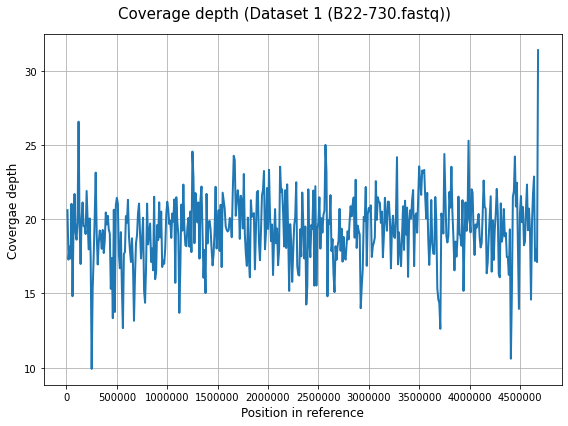

In [120]:
coverage(alignment, reference, title, folder=folder, step=10000)

Fully covered; mean coverage ~ 19.

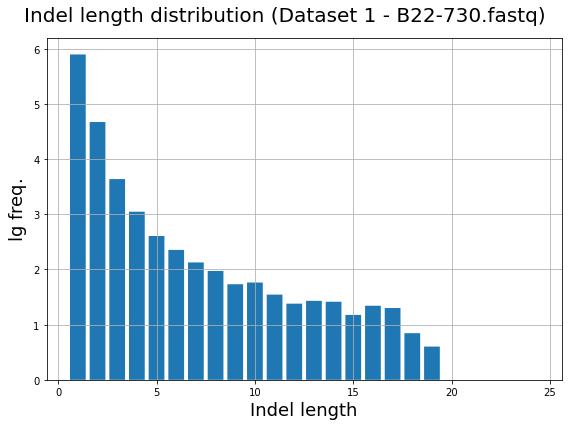

In [174]:
indel_distribution(alignment, folder, title)

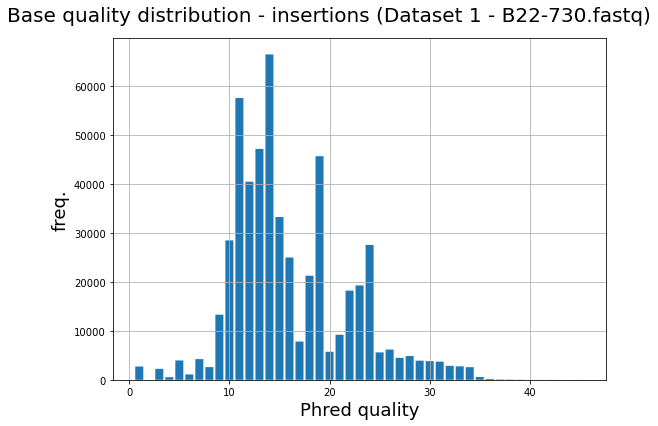

In [77]:
quality(alignment, folder, title=title, indels=True)

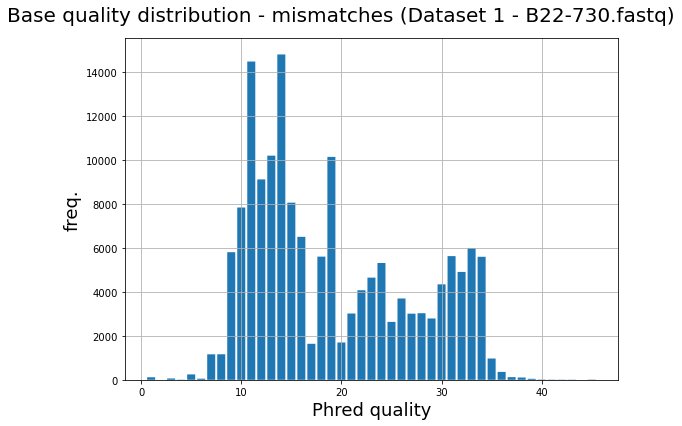

In [76]:
quality(alignment, folder, title=title, mismatches=True)

In [121]:
errorfreq(alignment, reference, folder)

Средний процент ошибок в ридах: 0.001%


,ref.A,ref.T,ref.G,ref.C,ref._
A,0,11325,17215,10360,183228
T,11173,0,10563,16671,184506
G,23657,9060,0,8092,79197
C,9147,24493,7209,0,79059
_,119254,119372,72804,72479,0


In [155]:
homopolymer_indel_percent(alignment, reference, folder)

13% of all indels are next to homopolymear fragments longer then 5 b.p.


### 2.2 Dataset 2 (C24-698.fastq.gz)

In [156]:
reads = 'C24-698.fastq'
reference = 'DH10B-K12.fasta'
folder = 'HW2_data/task2/C24-698/'
alignment  = 'alignment.sam'
title = 'Dataset 2 - C24-698.fastq'

In [133]:
bwa_index(reference, folder)
bwa_mem(reads, reference, folder, output=alignment)

[bwa_index] Pack FASTA... 0.08 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.18 seconds elapse.
[bwa_index] Update BWT... 0.05 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 0.46 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index DH10B-K12.fasta
[main] Real time: 2.628 sec; CPU: 1.839 sec

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 325862 sequences (80000235 bp)...
[M::process] read 326106 sequences (80000491 bp)...
[M::mem_process_seqs] Processed 325862 reads in 59.045 CPU sec, 7.591 real sec
[M::process] read 33438 sequences (7908842 bp)...
[M::mem_process_seqs] Processed 326106 reads in 57.185 CPU sec, 7.538 real sec
[M::mem_process_seqs] Processed 33438 reads in 5.875 CPU sec, 0.842 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 8 -o alignment.sam DH10B-K12.fasta C24-698.fastq
[main] Real time: 23.205 sec; CPU: 122.624 sec



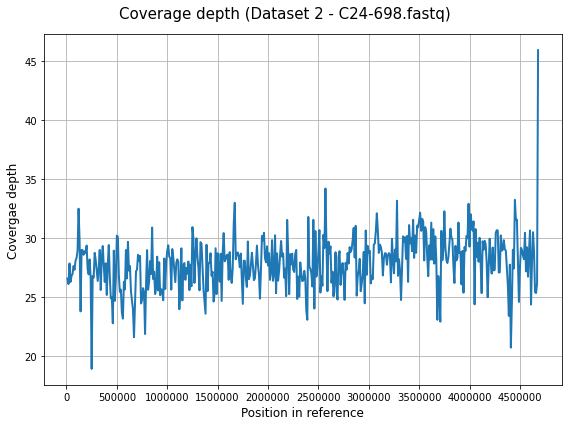

In [136]:
coverage(alignment, reference, title, folder=folder, step=10000)

Fully covered; mean coverage ~ 27.

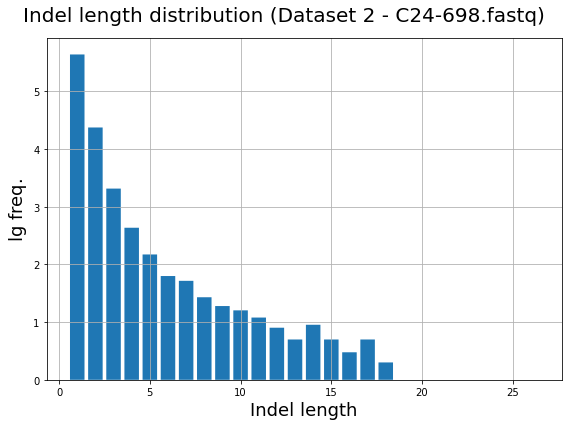

In [139]:
indel_distribution(alignment, folder, title)

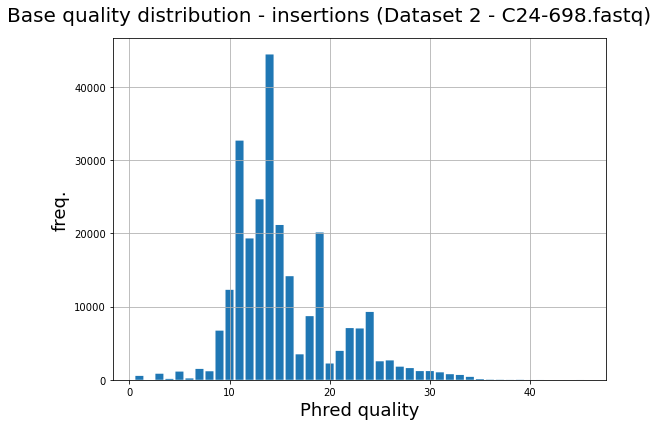

In [142]:
quality(alignment, folder, title=title, indels=True)

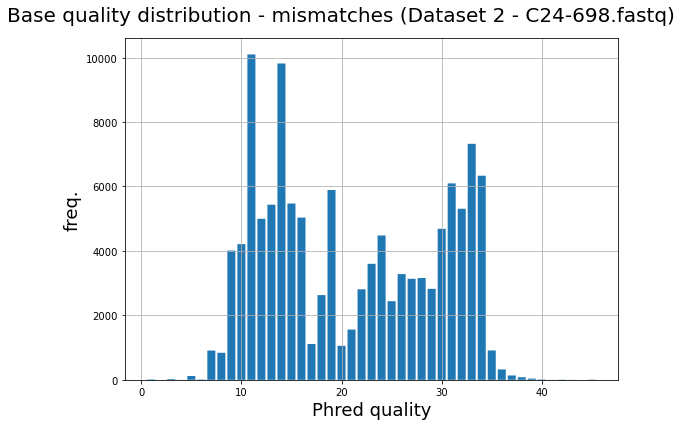

In [143]:
quality(alignment, folder, title=title, mismatches=True)

In [144]:
errorfreq(alignment, reference, folder)

Средний процент ошибок в ридах: 0.0%


,ref.A,ref.T,ref.G,ref.C,ref._
A,0,6549,14257,6751,80749
T,6488,0,7069,13966,81446
G,21938,5248,0,5380,46631
C,5124,22450,4978,0,47601
_,37199,37728,82142,82132,0


In [158]:
homopolymer_indel_percent(alignment, reference, folder)

7% of all indels are next to homopolymear fragments longer then 5 b.p.
